In [443]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

In [2]:
RANDOM_STATE = 123

# Getting the data

The dataset can be downloaded from Kaggle via this link [https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction/download] (requires Kaggle registration).  If you don't have a Kaggle account or just want to get it faster, you can use this link instead https://drive.google.com/uc?export=download&id=1VYo_Xb-RzwrHf0rcmpbMDcPSnRbdsqQn . After download, make sure that the dataset is in the same folder as the Jupyter notebook is running from.

# EDA

In [5]:
! ls

README.md              capstone-project.ipynb fake_job_postings.csv


In [445]:
df_raw= pd.read_csv("fake_job_postings.csv", header=0)

In [446]:
df_raw.reset_index(drop=True, inplace=True)
df_raw.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In this section, I'll explore the followings:
- missing values
- ranges of values
- analysis of the target variable
- feature importance analysis

Initial considerations:
 - column `job_id` is just a row ID, we're not gonna use it to build the model
 - apparently there are lots of NaN values, we should take care of them before building the model
 - the following columns are free text columns, thus will not be considered in details at this point: 
   `company_profile`, `description`, `requirements`, `benefits`
 - target variable is `fraudlent`


In [447]:
df_raw.drop("job_id", axis=1, inplace=True)
df_raw.isnull().sum()

title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [75]:
categorical_features = ["location", "department", "employment_type","required_experience", 
                        "required_education", "industry","function" ]


In [237]:
def plot_feature_w_cnt(feature, df=df_raw, top_n=40, size=(14,4)):
        plt.figure(figsize=size)
        plt_df = df[[feature]] \
                .groupby([feature]) \
                .agg(cnt_rec=(feature,"count")) \
                .sort_values(by="cnt_rec", ascending=False) \
                .reset_index()
        
        uniq_vals = plt_df[feature].nunique()
        print(f"number of unique vals is :{uniq_vals}")
        if uniq_vals <= top_n:
            display(plt_df)
            sns.barplot(x=plt_df[feature], y=plt_df["cnt_rec"])
        else: 
            print(f"there are more than {top_n} unique values. plotting the most frequent {top_n}")
            display(plt_df.iloc[:top_n])
            sns.barplot(x=plt_df[feature].iloc[:top_n], y=plt_df["cnt_rec"])

sns.set_theme(style="whitegrid")

### title

number of unique vals is :11231
there are more than 20 unique values. plotting the most frequent 20


,title,cnt_rec
0,English Teacher Abroad,311
1,Customer Service Associate,146
2,Graduates: English Teacher Abroad (Conversatio...,144
3,English Teacher Abroad,95
4,Software Engineer,86
5,English Teacher Abroad (Conversational),83
6,Customer Service Associate - Part Time,76
7,Account Manager,75
8,Web Developer,66
9,Project Manager,62


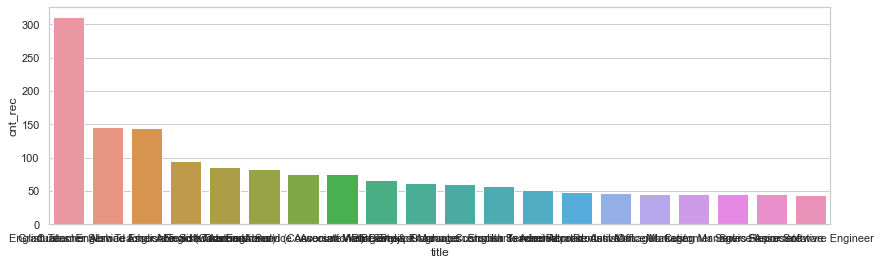

In [276]:
plot_feature_w_cnt("title", top_n=20)

- column `title` has 11231 unique values (we have 17880 records), and apparenttly it's more like free text thus we'll treat it that way 

### `department`

number of unique vals is :1337
there are more than 15 unique values. plotting the most frequent 15


,department,cnt_rec
0,Sales,551
1,Engineering,487
2,Marketing,401
3,Operations,270
4,IT,225
5,Development,146
6,Product,112
7,Information Technology,86
8,Technology,76
9,Design,76


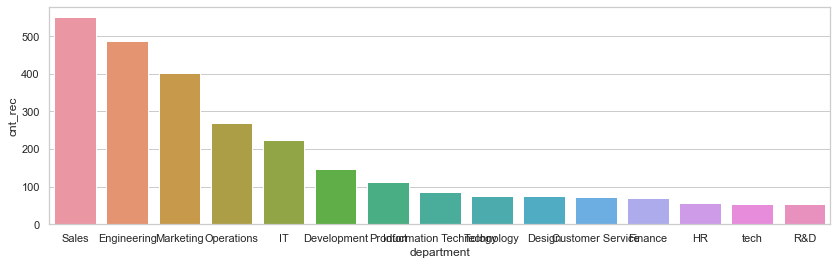

In [277]:
plot_feature_w_cnt("department", top_n=15)

### `employment_type`

number of unique vals is :5


,employment_type,cnt_rec
0,Full-time,11620
1,Contract,1524
2,Part-time,797
3,Temporary,241
4,Other,227


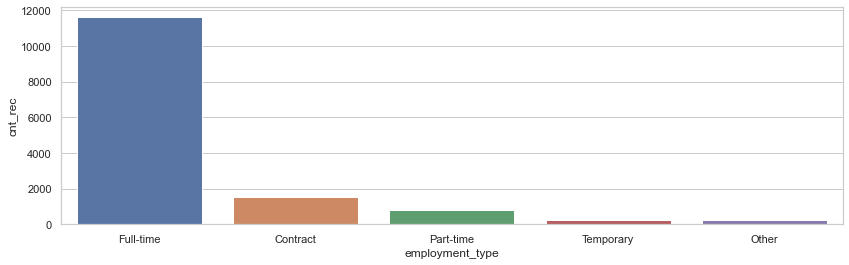

In [241]:
plot_feature_w_cnt("employment_type")



### `required_experience`

number of unique vals is :7


,required_experience,cnt_rec
0,Mid-Senior level,3809
1,Entry level,2697
2,Associate,2297
3,Not Applicable,1116
4,Director,389
5,Internship,381
6,Executive,141


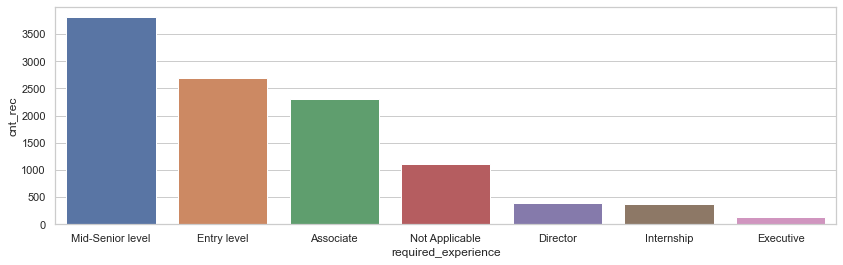

In [242]:
plot_feature_w_cnt("required_experience")

- for `required_experience` we have the value "Not Applicable" , what we can use to replace missing values

### `required_education`

,required_education,cnt_rec
0,Bachelor's Degree,5145
1,High School or equivalent,2080
2,Unspecified,1397
3,Master's Degree,416
4,Associate Degree,274
5,Certification,170
6,Some College Coursework Completed,102
7,Professional,74
8,Vocational,49
9,Some High School Coursework,27


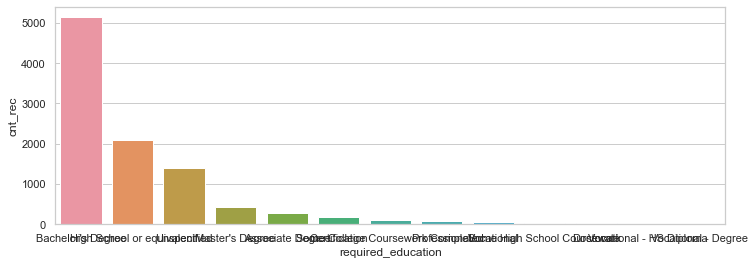

In [243]:
cnt_feature_vals("required_education")

- missing values to be filled with "Unspecified"

### industry

number of unique vals is :131
there are more than 20 unique values. plotting the most frequent 20


,industry,cnt_rec
0,Information Technology and Services,1734
1,Computer Software,1376
2,Internet,1062
3,Marketing and Advertising,828
4,Education Management,822
5,Financial Services,779
6,Hospital & Health Care,497
7,Consumer Services,358
8,Telecommunications,342
9,Oil & Energy,287


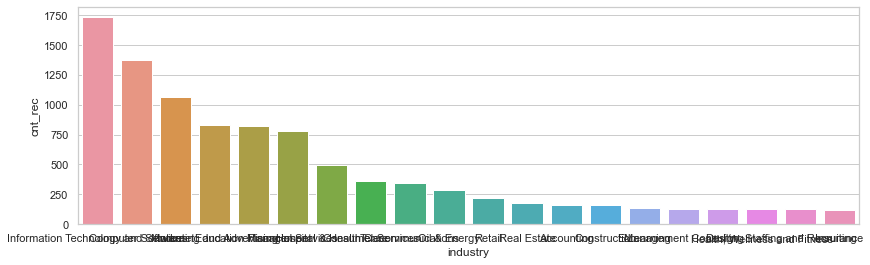

In [245]:
plot_feature_w_cnt("industry", top_n=20)

number of unique vals is :37
there are more than 20 unique values. plotting the most frequent 20


,function,cnt_rec
0,Information Technology,1749
1,Sales,1468
2,Engineering,1348
3,Customer Service,1229
4,Marketing,830
5,Administrative,630
6,Design,340
7,Health Care Provider,338
8,Other,325
9,Education,325


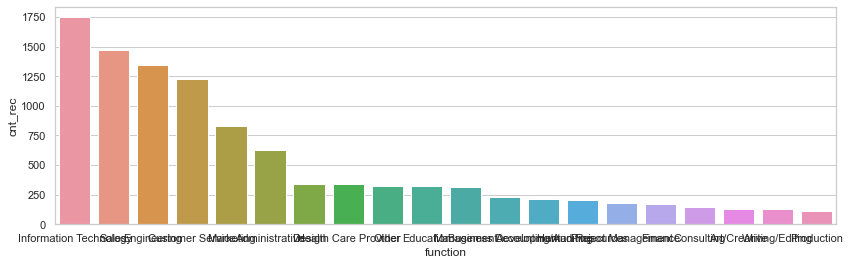

In [246]:
plot_feature_w_cnt("function",top_n=20)

### `salary_range`

number of unique vals is :874
there are more than 40 unique values. plotting the most frequent 40


,salary_range,cnt_rec
0,0-0,142
1,40000-50000,66
2,30000-40000,55
3,25000-30000,37
4,45000-67000,37
5,30000-50000,32
6,35000-45000,30
7,80000-100000,30
8,70000-90000,30
9,50000-80000,29


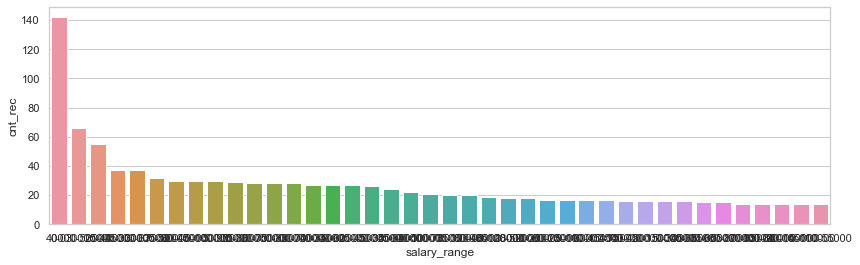

In [307]:
plot_feature_w_cnt("salary_range")

### `telecommuting`

number of unique vals is :2


,telecommuting,cnt_rec
0,0,17113
1,1,767


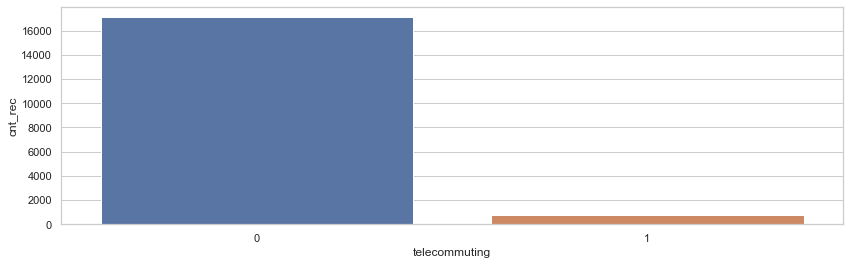

In [247]:
plot_feature_w_cnt("telecommuting")

number of unique vals is :2


,has_company_logo,cnt_rec
0,1,14220
1,0,3660


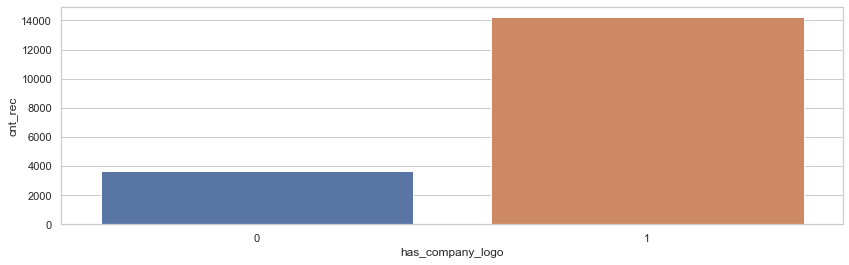

In [248]:
plot_feature_w_cnt("has_company_logo")

number of unique vals is :2


,has_questions,cnt_rec
0,0,9088
1,1,8792


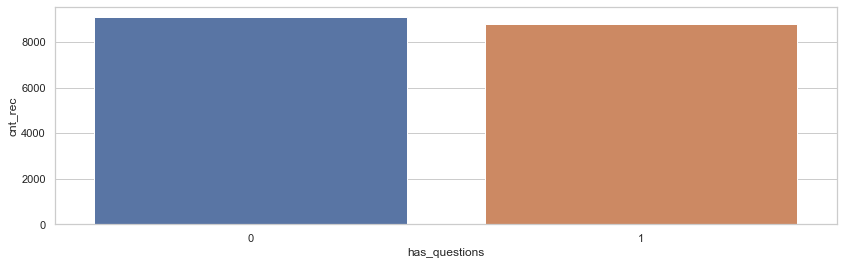

In [249]:
plot_feature_w_cnt("has_questions")

### target variable: `fraudulent`

number of unique vals is :2


,fraudulent,cnt_rec
0,0,17014
1,1,866


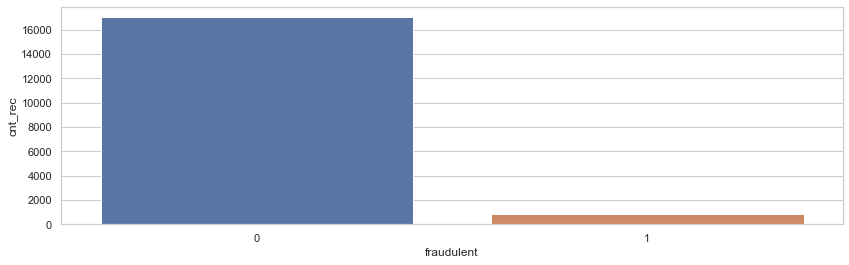

In [250]:
plot_feature_w_cnt("fraudulent")

only ~5% of the records are positive for fraud, we need to `stratify` the data when splitting

## Preprocessing #1

 - splitting `location` into `country` , `state`, `city`
 - substituting missing values

In [278]:
df_pre = df_raw.copy()

In [279]:
df_pre[["country", "state","city"]] = df_raw["location"].str.split(",", n=2,expand=True)

In [280]:
df_pre.drop("location", axis=1, inplace=True)

In [281]:
# replacing empty strings resulted by the splitting
df_pre =df_pre.replace(r'^\s*$', "unknown", regex=True) 

In [282]:
na_replacements = {"department":"unknown", "employment_type": "unknown" ,
                   "salary_range": "unknown", "company_profile":"unknown", "description":"unknown", 
                   "requirements":"unknown","benefits": "unknown",
                   "required_education": "Unspecified", "required_experience": "Not Applicable",
                   "country":"unknown", "state": "unknown", "city":"unknown",
                   "function": "other", "industry": "unknown"
                  ,}

In [283]:
for col ,replmnt in na_replacements.items():
    df_pre[col].fillna(replmnt,inplace=True)

In [284]:
df_pre.isnull().sum()

title                  0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
country                0
state                  0
city                   0
dtype: int64

### EDA step 2 - country/state/city distribution + calculating mutual information score

number of unique vals is :91
there are more than 20 unique values. plotting the most frequent 20


,country,cnt_rec
0,US,10656
1,GB,2384
2,GR,940
3,CA,457
4,DE,383
5,unknown,346
6,NZ,333
7,IN,276
8,AU,214
9,PH,132


number of unique vals is :325
there are more than 20 unique values. plotting the most frequent 20


,state,cnt_rec
0,unknown,2580
1,CA,2051
2,NY,1259
3,LND,992
4,TX,975
5,I,688
6,IL,424
7,FL,415
8,OH,372
9,VA,332


number of unique vals is :2387
there are more than 20 unique values. plotting the most frequent 20


,city,cnt_rec
0,unknown,2068
1,London,1060
2,New York,669
3,Athens,542
4,San Francisco,477
5,Houston,271
6,Berlin,262
7,Chicago,257
8,Washington,255
9,Auckland,227


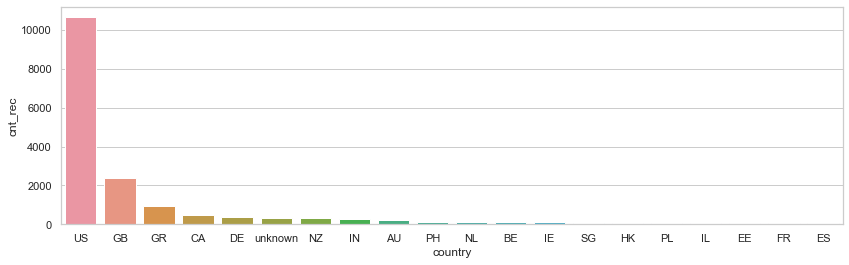

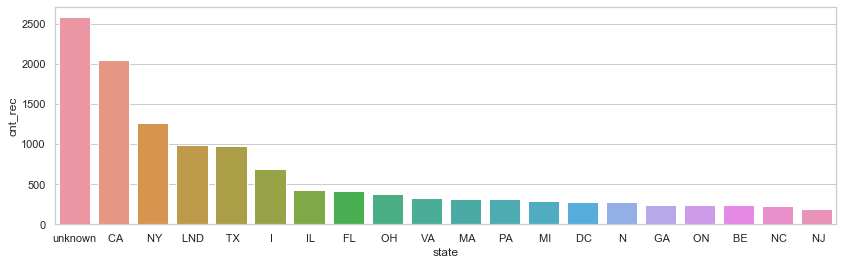

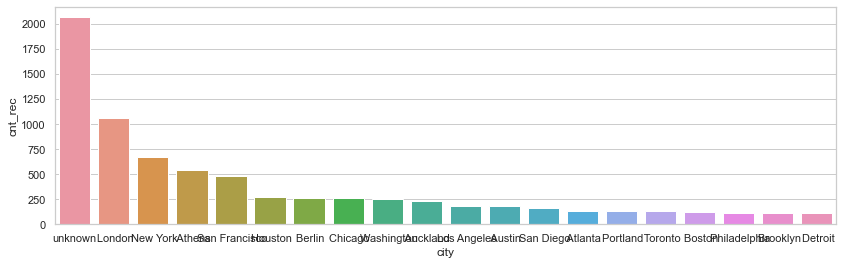

In [285]:
for feat in ["country", "state", "city"]:
    plot_feature_w_cnt(feat, top_n=20, df=df_pre)

In [264]:
from sklearn.metrics import mutual_info_score

In [286]:
def calc_mutual_info(features):
    mi = {"column":list(), "score": list()}
    for f in features:
        mi["column"].append(f)
        mi["score"].append(mutual_info_score(df_pre["fraudulent"], df_pre[f] ))
        
    return mi

In [287]:
mis_data = calc_mutual_info(["telecommuting", "has_company_logo", "has_questions", 
                        "city","state","country", "salary_range",
                        "department", "employment_type","required_experience", 
                        "required_education", "industry","function" ])

In [288]:
df_mis = pd.DataFrame.from_dict(mis_data)

In [289]:
df_mis.sort_values(by="score", ascending=False)

,column,score
3,city,0.091349
7,department,0.047241
11,industry,0.031548
6,salary_range,0.027874
1,has_company_logo,0.026454
4,state,0.026324
5,country,0.018283
12,function,0.013993
10,required_education,0.008048
2,has_questions,0.004336


### Preprocessing: train/test split, vectorizing

In [336]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


df_train, df_test = train_test_split(df_pre, 
                                     test_size=0.2 , 
                                     random_state=RANDOM_STATE, stratify=df_pre["fraudulent"])

In [337]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [390]:
df_train.iloc[:10]

,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,country,state,city
0,Senior Software Engineer - Backend,R&D,unknown,WellAware is an oil field communications and s...,The Senior Software Engineer is highly experie...,Essential Duties and Responsibilities: Works ...,unknown,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Oil & Energy,Engineering,US,TX,Austin/San Antonio
1,Customer Engagement Analyst,unknown,unknown,"Curvo Labs is an exciting, funded start-up det...","Curvo Labs is an exciting early stage, funded ...",RequirementsA proven track record of success i...,All employees have benefits and the ability to...,1,1,1,Full-time,Not Applicable,Bachelor's Degree,Hospital & Health Care,Business Analyst,US,IN,Evansville
2,Full Stack Web Developer,unknown,unknown,"S2scout, is a Pittsburgh-based talent aquisiti...",Our client is seeking a skilled #URL_01a736d89...,2+ years #URL_01a736d89d2f0b19de700923d2c31283...,Full benefitsCompetitive bonus &amp; 401k prog...,0,1,0,Full-time,Not Applicable,Bachelor's Degree,Marketing and Advertising,Information Technology,US,unknown,unknown
3,Director of Peri-Anesthesia,unknown,unknown,unknown,Apply using below link directly#URL_af5a535903...,unknown,unknown,0,0,0,Full-time,Not Applicable,Unspecified,Hospital & Health Care,other,US,MA,unknown
4,General Manager - Phoenix,Operations,unknown,"Shyp is the easiest way to send anything, anyw...",Shyp is looking for the best of the best to le...,"5+ years experience with building, managing, a...",Opportunity to play a huge role in a unicorn s...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Logistics and Supply Chain,Management,US,AZ,Phoenix
5,Automotive Crash Analyst,unknown,70000-85000,Cresttek is a subsidiary of American Hydrostat...,Responsible for the creation and documentation...,Required Skills and Abilities: - Minimum of 3 ...,unknown,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Automotive,Engineering,US,OH,Marysville
6,Payroll Data Coordinator Positions - Earn $100...,unknown,unknown,unknown,We are a full-service marketing and staffing f...,RequirementsAll you need is access to the Inte...,This is an entry level position and we offer f...,0,0,0,unknown,Not Applicable,Unspecified,unknown,other,US,LA,Abbeville
7,"Software Engineer (Apps, Web Services)",unknown,unknown,"Wallflowr is a Cambridge, MA based company wor...",OverviewWe are a self-funded startup based in ...,- 2+ years of relevant work experience in soft...,- Get into a startup early with an experienced...,0,1,1,Full-time,Not Applicable,Bachelor's Degree,Consumer Electronics,Engineering,US,MA,Cambridge
8,Fluid Technician,unknown,unknown,"At Harrigan Solutions, we help companies becom...","Harrigan Solutions, LLC is in need of a Fluid ...",A successful candidate will have the following...,Harrigan offers a competitive salary and benef...,0,0,0,Full-time,Not Applicable,High School or equivalent,unknown,other,US,WI,Marinette
9,Android Engineer,Android,unknown,"We're an emerging technology agency, and we bu...","As an Android Engineer at Mutual Mobile, you'l...",You'll probably love this job if:You're passio...,Why work for Mutual Mobile? We craft beautiful...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Engineering,US,TX,Austin


In [338]:
y_train = df_train.fraudulent
y_test = df_test.fraudulent

In [339]:
df_train.drop("fraudulent",axis=1, inplace=True)
df_test.drop("fraudulent",axis=1, inplace=True)

In [305]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

In [386]:
col_transformations2= [
    ("numerical", "passthrough", ["telecommuting", "has_company_logo", "has_questions"]),
    ("categories", OneHotEncoder(dtype="int32"), ["employment_type", "required_experience", "required_education"]),
    ("department", CountVectorizer(min_df=30, dtype="int32") ,"department"),
    ("industry", CountVectorizer(min_df=30, dtype="int32") ,"industry"),
    ("function", CountVectorizer(min_df=30, dtype="int32") ,"function"),
    ("salary_range", CountVectorizer(min_df=20, dtype="int32") ,"salary_range"),
    ("country", CountVectorizer(min_df=40, dtype="int32") ,"country"),
    ("state", CountVectorizer(min_df=40, dtype="int32") ,"state"),
    ("city", CountVectorizer(min_df=30, dtype="int32") ,"city"),
    ("title",  TfidfVectorizer(lowercase=True, stop_words="english", min_df=30), "title"),
    ("company_profile",  TfidfVectorizer(lowercase=True, stop_words="english", min_df=30), "company_profile"),
    ("requirements",  TfidfVectorizer(lowercase=True, stop_words="english", min_df=40), "requirements"),
    ("description",  TfidfVectorizer(lowercase=True, stop_words="english", min_df=50), "description"),
    ("benefits",  TfidfVectorizer(lowercase=True, stop_words="english", min_df=30), "benefits"),
]

In [387]:
transformer = ColumnTransformer(col_transformations2, remainder="drop")
transformer.fit(df_train)

ColumnTransformer(transformers=[('numerical', 'passthrough',
                                 ['telecommuting', 'has_company_logo',
                                  'has_questions']),
                                ('categories', OneHotEncoder(dtype='int32'),
                                 ['employment_type', 'required_experience',
                                  'required_education']),
                                ('department',
                                 CountVectorizer(dtype='int32', min_df=30),
                                 'department'),
                                ('industry',
                                 CountVectorizer(dtype='int32', min_df=30),
                                 'industr...
                                 TfidfVectorizer(min_df=30,
                                                 stop_words='english'),
                                 'title'),
                                ('company_profile',
                                 TfidfVe

In [393]:
X_train = transformer.transform(df_train)

## Building the model

### 1st try: simple logistic regression

In [391]:
from sklearn.linear_model import LogisticRegression

In [410]:
perf_metrics=list()
best_f1=0.0
best_f1_model=None
best_roc_auc=0.0
best_roc_model =None

In [394]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

/Users/abarabas/devel/jupyter/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [396]:
X_test = transformer.transform(df_test)

In [404]:
from sklearn.metrics import roc_auc_score, f1_score

In [397]:
y_pred = lr.predict(X_test)

In [398]:
accuracy_score(y_test, y_pred)

0.9821029082774049

In [400]:
roc_auc_score(y_test, y_pred)

0.8287451228854513

In [401]:
f1_score(y_test, y_pred)

0.7808219178082192

In [407]:
perf_metrics.append({"model_name": str(lr),"model": lr, "tuning": None, 
                     "f1": f1_score(y_test, y_pred),
                    "roc_auc": roc_auc_score(y_test, y_pred)})


### RidgeClassifier with different settings

In [409]:
from sklearn.linear_model import RidgeClassifier

In [412]:
def run_ridge_experiment(alpha):

    ridge = RidgeClassifier(alpha=alpha, random_state=RANDOM_STATE)
    ridge.fit(X_train, y_train)
    y_pred_rdg = ridge.predict(X_test)
    return ridge, roc_auc_score(y_test, y_pred_rdg), f1_score(y_test, y_pred_rdg) 


alphas = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.6, 1]
for a in alphas:
    ridge, rocauc, f1 = run_ridge_experiment(a)
    if rocauc > best_roc_auc:
        best_roc_auc = rocauc
        best_roc_model = str(ridge)
    if f1 > best_f1:
        best_f1= f1
        best_f1_model = str(ridge)
    print(f"Ridge, alpha={a} : ROCAUC: {rocauc} F1: {f1}")
    perf_metrics.append({"model_name": str(ridge), "model": ridge, "tuning": {"alpha":a}, "roc_auc": rocauc, "f1":f1})


Ridge, alpha=0 : ROCAUC: 0.8627927755007058 F1: 0.6649616368286445
Ridge, alpha=1e-05 : ROCAUC: 0.8599026020903011 F1: 0.6615384615384616
Ridge, alpha=0.0001 : ROCAUC: 0.8630866338609761 F1: 0.6683804627249358
Ridge, alpha=0.001 : ROCAUC: 0.8642620673020575 F1: 0.6824146981627297
Ridge, alpha=0.01 : ROCAUC: 0.8662205568361135 F1: 0.7435158501440922
Ridge, alpha=0.1 : ROCAUC: 0.8712161489607095 F1: 0.8242811501597443
Ridge, alpha=0.2 : ROCAUC: 0.8720977240415205 F1: 0.8403908794788273
Ridge, alpha=0.3 : ROCAUC: 0.8696483381715215 F1: 0.8448844884488449
Ridge, alpha=0.5 : ROCAUC: 0.866905093941252 F1: 0.8438538205980066
Ridge, alpha=0.6 : ROCAUC: 0.8670520231213873 F1: 0.8466666666666667
Ridge, alpha=1 : ROCAUC: 0.8583815028901733 F1: 0.8350168350168351


In [414]:
best_f1_model, best_roc_model

('RidgeClassifier(alpha=0.6, random_state=123)',
 'RidgeClassifier(alpha=0.2, random_state=123)')

### DecisionTreeClassifier with different settings

- from now on , the target is improving roc auc only. f1 scores will be recorded though

In [413]:
from sklearn.tree import DecisionTreeClassifier

In [419]:
def run_treeclassifier_experiment(max_depth, min_samples_split=2, min_samples_leaf=1):

    tclf = DecisionTreeClassifier(max_depth=max_depth,
                                 min_samples_split=min_samples_split, 
                                 min_samples_leaf=min_samples_leaf, random_state=RANDOM_STATE)
    tclf.fit(X_train,y_train)
    y_pred_tclf = tclf.predict(X_test)
    return tclf, round(roc_auc_score(y_test, y_pred_tclf),3), round(f1_score(y_test, y_pred_tclf),3)

depths=range(1,30,2)
min_splits=[2,3,5,10,15,50,100,150,200]
min_leafs=[1, 5, 10, 15, 20, 50, 100, 200]

tclf_best_roc_auc = 0.0
tclf_best_f1 = 0.0
best_depth_f1=None
best_depth_f1= 0.0
for d in depths:
    _model, _rocauc, _f1 = run_treeclassifier_experiment(max_depth=d)
    if _rocauc > tclf_best_roc_auc:
        best_depth = d
        tclf_best_roc_auc= _rocauc
        if _rocauc > best_roc_auc:
            best_roc_auc = _rocauc
            best_roc_model = _model
    if _f1 > tclf_best_f1:
        tclf_best_f1 = _f1
        if _f1> best_f1:
            best_f1= _f1
    print(f"DecisionTreeClassifier, max_depth={d} : ROCAUC: {_rocauc} F1: {_f1}")
    perf_metrics.append({"model_name": str(_model), "model": _model, "tuning": {"max_depth":d}, 
                         "roc_auc": _rocauc, "f1":_f1})

DecisionTreeClassifier, max_depth=1 : ROCAUC: 0.5 F1: 0.0
DecisionTreeClassifier, max_depth=3 : ROCAUC: 0.646 F1: 0.44
DecisionTreeClassifier, max_depth=5 : ROCAUC: 0.738 F1: 0.613
DecisionTreeClassifier, max_depth=7 : ROCAUC: 0.788 F1: 0.707
DecisionTreeClassifier, max_depth=9 : ROCAUC: 0.822 F1: 0.752
DecisionTreeClassifier, max_depth=11 : ROCAUC: 0.825 F1: 0.753
DecisionTreeClassifier, max_depth=13 : ROCAUC: 0.842 F1: 0.783
DecisionTreeClassifier, max_depth=15 : ROCAUC: 0.845 F1: 0.782
DecisionTreeClassifier, max_depth=17 : ROCAUC: 0.85 F1: 0.78
DecisionTreeClassifier, max_depth=19 : ROCAUC: 0.865 F1: 0.801
DecisionTreeClassifier, max_depth=21 : ROCAUC: 0.864 F1: 0.794
DecisionTreeClassifier, max_depth=23 : ROCAUC: 0.867 F1: 0.8
DecisionTreeClassifier, max_depth=25 : ROCAUC: 0.873 F1: 0.805
DecisionTreeClassifier, max_depth=27 : ROCAUC: 0.876 F1: 0.814
DecisionTreeClassifier, max_depth=29 : ROCAUC: 0.875 F1: 0.799


In [421]:
best_roc_auc, best_roc_model.max_depth

(0.876, 27)

In [424]:
best_min_split=0
tclf_best_roc_auc=0
tclf_best_f1=0
for ms in min_splits:
    _model, _rocauc, _f1 = run_treeclassifier_experiment(max_depth=27, min_samples_split=ms)
    if _rocauc > tclf_best_roc_auc:
        best_min_split = ms
        tclf_best_roc_auc= _rocauc
        if _rocauc > best_roc_auc:
            best_roc_auc = _rocauc
            best_roc_model = _model
    if _f1 > tclf_best_f1:
        tclf_best_f1 = _f1
        if _f1> best_f1:
            best_f1= _f1
    print(f"DecisionTreeClassifier, min_splits={ms} : ROCAUC: {_rocauc} F1: {_f1}")
    perf_metrics.append({"model_name": str(_model), "model": _model, "tuning": {"max_depth":27, "min_splits":ms}, 
                         "roc_auc": _rocauc, "f1":_f1})

DecisionTreeClassifier, min_splits=2 : ROCAUC: 0.876 F1: 0.814
DecisionTreeClassifier, min_splits=3 : ROCAUC: 0.876 F1: 0.814
DecisionTreeClassifier, min_splits=5 : ROCAUC: 0.878 F1: 0.805
DecisionTreeClassifier, min_splits=10 : ROCAUC: 0.87 F1: 0.801
DecisionTreeClassifier, min_splits=15 : ROCAUC: 0.875 F1: 0.799
DecisionTreeClassifier, min_splits=50 : ROCAUC: 0.846 F1: 0.763
DecisionTreeClassifier, min_splits=100 : ROCAUC: 0.856 F1: 0.746
DecisionTreeClassifier, min_splits=150 : ROCAUC: 0.874 F1: 0.739
DecisionTreeClassifier, min_splits=200 : ROCAUC: 0.874 F1: 0.739


In [425]:
best_min_split

5

In [426]:
best_min_leaves=0
tclf_best_roc_auc=0
tclf_best_f1=0
for ml in min_leafs:
    _model, _rocauc, _f1 = run_treeclassifier_experiment(max_depth=27, 
                                                         min_samples_split=best_min_split,
                                                        min_samples_leaf=ml)
    if _rocauc > tclf_best_roc_auc:
        best_min_leaves = ml
        tclf_best_roc_auc= _rocauc
        if _rocauc > best_roc_auc:
            best_roc_auc = _rocauc
            best_roc_model = _model
    if _f1 > tclf_best_f1:
        tclf_best_f1 = _f1
        if _f1> best_f1:
            best_f1= _f1
    print(f"DecisionTreeClassifier, min_samples_leaf={ml} : ROCAUC: {_rocauc} F1: {_f1}")
    perf_metrics.append({"model_name": str(_model), "model": _model, 
                         "tuning": {"max_depth":27, "min_splits":5,"min_samples_leaf": ml }, 
                         "roc_auc": _rocauc, "f1":_f1})

DecisionTreeClassifier, min_samples_leaf=1 : ROCAUC: 0.878 F1: 0.805
DecisionTreeClassifier, min_samples_leaf=5 : ROCAUC: 0.855 F1: 0.777
DecisionTreeClassifier, min_samples_leaf=10 : ROCAUC: 0.829 F1: 0.74
DecisionTreeClassifier, min_samples_leaf=15 : ROCAUC: 0.816 F1: 0.703
DecisionTreeClassifier, min_samples_leaf=20 : ROCAUC: 0.801 F1: 0.669
DecisionTreeClassifier, min_samples_leaf=50 : ROCAUC: 0.738 F1: 0.575
DecisionTreeClassifier, min_samples_leaf=100 : ROCAUC: 0.643 F1: 0.403
DecisionTreeClassifier, min_samples_leaf=200 : ROCAUC: 0.5 F1: 0.0


In [428]:
best_min_leaves, tclf_best_roc_auc

(1, 0.878)

### RandomForestClassifier with different settings


In [436]:
from sklearn.ensemble import RandomForestClassifier

def run_randomforest_experiment(max_depth, min_samples_split=2, min_samples_leaf=1):

    rfor = RandomForestClassifier(max_depth=max_depth,
                                 min_samples_split=min_samples_split, 
                                 min_samples_leaf=min_samples_leaf, 
                                 random_state=RANDOM_STATE)
    rfor.fit(X_train,y_train)
    y_pred_rfor = rfor.predict(X_test)
    return rfor, round(roc_auc_score(y_test, y_pred_rfor),3), round(f1_score(y_test, y_pred_rfor),3)

depths=range(1,60,2)
min_splits=[2,3,5,10,15,50,100,150,200]
min_leafs=[1, 5, 10, 15, 20, 50, 100, 200]

rfor_best_roc_auc = 0.0
rfor_best_f1 = 0.0
rfor_best_depth=-1
for d in depths:
    _model, _rocauc, _f1 = run_randomforest_experiment(max_depth=d)
    if _rocauc > rfor_best_roc_auc:
        rfor_best_depth = d
        rfor_best_roc_auc= _rocauc
        if _rocauc > best_roc_auc:
            best_roc_auc = _rocauc
            best_roc_model = _model
    if _f1 > rfor_best_f1:
        rfor_best_f1 = _f1
        if _f1> best_f1:
            best_f1= _f1
    print(f"RandomForestClassifier, max_depth={d} : ROCAUC: {_rocauc} F1: {_f1}")
    perf_metrics.append({"model_name": str(_model), "model": _model, "tuning": {"max_depth":d}, 
                        "roc_auc": _rocauc, "f1":_f1})

RandomForestClassifier, max_depth=1 : ROCAUC: 0.5 F1: 0.0
RandomForestClassifier, max_depth=3 : ROCAUC: 0.517 F1: 0.067
RandomForestClassifier, max_depth=5 : ROCAUC: 0.543 F1: 0.16
RandomForestClassifier, max_depth=7 : ROCAUC: 0.575 F1: 0.261
RandomForestClassifier, max_depth=9 : ROCAUC: 0.604 F1: 0.344
RandomForestClassifier, max_depth=11 : ROCAUC: 0.636 F1: 0.427
RandomForestClassifier, max_depth=13 : ROCAUC: 0.676 F1: 0.521
RandomForestClassifier, max_depth=15 : ROCAUC: 0.694 F1: 0.558
RandomForestClassifier, max_depth=17 : ROCAUC: 0.711 F1: 0.593
RandomForestClassifier, max_depth=19 : ROCAUC: 0.72 F1: 0.61
RandomForestClassifier, max_depth=21 : ROCAUC: 0.728 F1: 0.627
RandomForestClassifier, max_depth=23 : ROCAUC: 0.734 F1: 0.638
RandomForestClassifier, max_depth=25 : ROCAUC: 0.743 F1: 0.654
RandomForestClassifier, max_depth=27 : ROCAUC: 0.743 F1: 0.654
RandomForestClassifier, max_depth=29 : ROCAUC: 0.754 F1: 0.674
RandomForestClassifier, max_depth=31 : ROCAUC: 0.763 F1: 0.689
Rand

In [434]:
rfor_best_roc_auc

0.812

- apparently, RandomForestClassifier will not result such a good ROC AUC as DecisionTreeClassifier, so stopping here
- let's check which is the best model!

In [437]:
best_roc_model

DecisionTreeClassifier(max_depth=27, min_samples_split=5, random_state=123)

In [438]:
import pickle

In [442]:
with open("capstone_model.pickle","wb") as pf:
    pickle.dump(best_roc_model, pf)